# ENCS5343 :Computer Vision
<h4>Assignment 2: <br> Arabic Handwritten Text Identification Using Local Feature Extraction Techniques </h4>

<h4> <b>Mohammed Abed Alkareem - 1210708</b> </h4>

In [1]:
!pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


## Dataset Download

Dataset Link: https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e

<p>The dataset contains 65 different Arabic alphabets (with variations on begin, middle, end and regular alphabets), 10 different Arabic words (that encompass all Arabic alphabets) and 3 different paragraphs. The dataset was collected anonymously from 82 different users. Each user was asked to write each alphabet and word 10 times. A userid uniquely but anonymously identifies the writer of each alphabet, word and paragraph. In total, the dataset consists of 53199 alphabet images, 8144 word images and 241 paragraph images.</p>

- The file **"isolated_words_per_user.zip"** contains 8144 Arabic words organized into one folder per user

In [ ]:
# download the dataset from the Mendeley Data 
!wget https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded -O isolated_words_per_user.zip

In [5]:
# unzip the dataset

import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('isolated_words_per_user')

## Procedure

### Importing Libraries

In [1]:
from utils.algorithms import extract_features , sift, get_vBOW_image, orb
import torch
import torchvision
import cv2 as cv
import time
import numpy as np

ModuleNotFoundError: No module named 'faiss'

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1)
])


data = torchvision.datasets.ImageFolder(root='isolated_words_per_user/isolated_words_per_user',
                                         transform=transform)

train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

train_size = int(0.8 * len(data))

test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)



In [3]:
images , labels = next(iter(train_loader))

In [4]:
images.shape

torch.Size([1, 1, 128, 146])

In [5]:
print("Number of training samples: ", len(train_loader))
train_classes = set([data.classes[label] for _, label in train_dataset])
test_classes = set([data.classes[label] for _, label in test_dataset])

print("Number of classes in training", len(train_classes))
print("Number of classes in testing", len(test_classes))

assert len(train_classes) == len(data.classes), "Training set does not contain all classes"
assert len(test_classes) == len(data.classes), "Testing set does not contain all classes"
print("Number of testing samples: ", len(test_loader))


Number of training samples:  6515
Number of classes in training 82
Number of classes in testing 82
Number of testing samples:  1629


In [5]:
classes = data.classes

Label:  user033


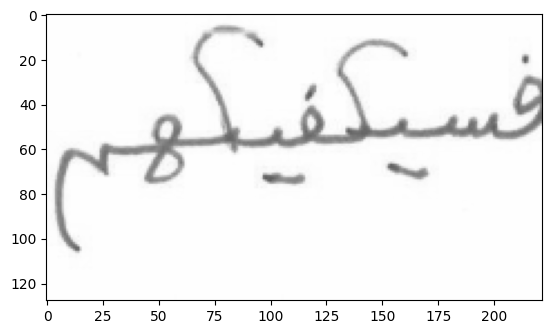

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

#print the label
print("Label: ", classes[labels.item()])

# show images
imshow(torchvision.utils.make_grid(images))
print("===============================================")

    
  

In [13]:

# Extract features and labels
features, labels, kmeans = extract_features(train_loader, algorithm='sift', numOfClusters=200)


Number of images:  6515
Clustering descriptors...
<class 'list'>


KeyboardInterrupt: 

In [8]:
test_features, test_labels = extract_features(test_loader, algorithm='sift', Test=True, kMeans=kmeans)

Number of images:  1629


In [9]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

print("Number of training samples: ", len(X_train))
print("Number of validation samples: ", len(X_val))



Number of training samples:  5212
Number of validation samples:  1303


In [ ]:
#train random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# grid search
n_estimators = [50, 100, 150, 200]
max_features = ['log2', 'sqrt']

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    clf, 
    param_grid={'n_estimators': n_estimators, 'max_features': max_features}, 
    cv=5, 
    n_jobs=2 
)


grid_search.fit(features, labels)

print("Best parameters: ", grid_search.best_params_)

# clf = RandomForestClassifier(n_estimators=150, random_state=42)
# clf.fit(X_train, y_train)

# # Predict on the validation set
# y_pred = clf.predict(X_val)

# # Calculate accuracy

# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy: ", accuracy)

# #test the model
# features_test, labels_test, _ = extract_features(test_loader, algorithm='sift', numOfClusters=100)



Best parameters:  {'max_features': 'log2', 'n_estimators': 200}


In [10]:
grid_search.best_score_


0.21719109746738297

In [12]:
#tesst the model

from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.2222222222222222


### Testing Feature Extraction Techniques on a Single Image

In [2]:
imgGrey = cv.imread('test_img.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
type(imgGrey)

numpy.ndarray

#### 1. SIFT Feature Extraction

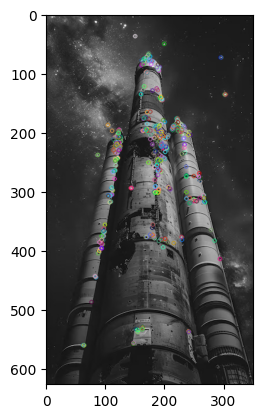

In [4]:
keypoints, des=orb(imgGrey, test=True)

In [5]:
len(keypoints)

500

In [6]:
des.shape

(500, 32)

(#keypoints, 128)

#### SURF Feature Extraction

This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'

In [3]:
keypoints , des = surf(imgGrey)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


### Getting Feature Vectors for All Images

#### SIFT Feature Extraction

In [2]:

start = time.time()
fv , kmean, invertedFile = get_feature_vectors(images_path='isolated_words_per_user',
                     algorithm='sift', 
                     numOfClusters=100)

print('Time taken:', time.time()-start)
# print mm:ss
print('Time taken:', time.strftime('%M:%S', time.gmtime(time.time()-start)))


Finished extracting BOW descriptors for 8144 images ^_^
Finished clustering BOW descriptors into 100 clusters ^_^
Finished getting BOW featureVectors for 8144 images ^_^
Time taken: 174.44448685646057
Time taken: 02:54


In [3]:
fv.shape

(8144, 100)

In [13]:
fv[0].shape

(100,)

In [14]:

#sort inverted file
invertedFile = dict(sorted(invertedFile.items()))

for i in list(invertedFile.keys()):
    print(i,"->", len(invertedFile[i]), end=' | ')
    

0 -> 2420 | 1 -> 5736 | 2 -> 3193 | 3 -> 3377 | 4 -> 3545 | 5 -> 5097 | 6 -> 3701 | 7 -> 3158 | 8 -> 5539 | 9 -> 3252 | 10 -> 4500 | 11 -> 3822 | 12 -> 3684 | 13 -> 3597 | 14 -> 4683 | 15 -> 3986 | 16 -> 5515 | 17 -> 3834 | 18 -> 3393 | 19 -> 4107 | 20 -> 3750 | 21 -> 5058 | 22 -> 4095 | 23 -> 4660 | 24 -> 4297 | 25 -> 6135 | 26 -> 2569 | 27 -> 4152 | 28 -> 3119 | 29 -> 3263 | 30 -> 3923 | 31 -> 3595 | 32 -> 4172 | 33 -> 3757 | 34 -> 4545 | 35 -> 4579 | 36 -> 2024 | 37 -> 3428 | 38 -> 3158 | 39 -> 3540 | 40 -> 4214 | 41 -> 4123 | 42 -> 3549 | 43 -> 3330 | 44 -> 6653 | 45 -> 3539 | 46 -> 5841 | 47 -> 2864 | 48 -> 3615 | 49 -> 5008 | 50 -> 3706 | 51 -> 3058 | 52 -> 5154 | 53 -> 4532 | 54 -> 3971 | 55 -> 4644 | 56 -> 2832 | 57 -> 3327 | 58 -> 3109 | 59 -> 3500 | 60 -> 3347 | 61 -> 4328 | 62 -> 1819 | 63 -> 3423 | 64 -> 2982 | 65 -> 3128 | 66 -> 3456 | 67 -> 3837 | 68 -> 4196 | 69 -> 2763 | 70 -> 4122 | 71 -> 3915 | 72 -> 3592 | 73 -> 4802 | 74 -> 4183 | 75 -> 4387 | 76 -> 2701 | 77 -> 324

In [19]:
#based on des of the image we can get the feature vector of the image
cluster = kmean.predict(des.astype(np.float64))

# get the feature vector of the image
feature_vector = np.zeros(len(kmean.cluster_centers_))

for i in cluster:
    feature_vector[i] += 1

feature_vector

array([12.,  3.,  5.,  8.,  7.,  2.,  1.,  0.,  2., 67.,  0.,  1.,  0.,
        0.,  1., 13.,  6.,  4.,  0.,  1.,  3.,  1.,  2.,  3.,  0.,  0.,
        8.,  0.,  4.,  4., 10., 15.,  1.,  9.,  1.,  0., 78., 24., 15.,
        0.,  4., 53.,  4.,  4.,  1.,  0.,  1.,  3.,  6.,  1., 13.,  8.,
        1.,  5.,  3.,  0., 10., 20.,  5.,  4.,  5.,  4.,  0.,  3.,  0.,
        1.,  0.,  7., 10., 12.,  0.,  0.,  0.,  1.,  9.,  0.,  4.,  6.,
        9.,  1.,  9.,  6.,  0.,  1., 16.,  3.,  7.,  3.,  0.,  9.,  8.,
        0.,  0., 11.,  6., 19.,  1., 11.,  3.,  6.])

In [24]:
cluster.shape

(648,)

In [20]:
# get the matching images based on the feature vector of the image and the inverted file 
matching_images = []
for i in cluster:
    if i in invertedFile.keys():
        matching_images += invertedFile[i]

matching_images = list(set(matching_images))

In [22]:
len(matching_images)

8144

In [ ]:

for i in matching_images:
    


In [7]:
len(invertedFile.keys())


100

In [ ]:
np.save('sift_fv.npy', fv)

In [ ]:

fv[0].shape # 100 cluster


(100,)

In [10]:
fv[0]

array([ 3.,  0.,  0.,  3.,  3.,  1.,  2.,  2.,  3.,  1.,  2.,  0.,  2.,
        0.,  3.,  0.,  2.,  1., 16.,  3.,  0.,  1.,  4.,  2.,  2.,  0.,
        4.,  9.,  0.,  1.,  6.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  2.,  0.,  2.,  3.,  0.,  3.,  3.,  2.,  4.,  2.,  4.,  3.,
        1.,  3.,  0., 10.,  4.,  0.,  5.,  4.,  0.,  0.,  3.,  2.,  0.,
        0.,  6.,  1.,  3.,  0.,  4.,  0.,  6.,  0.,  1.,  0.,  1.,  1.,
        0.,  2.,  0.,  1.,  1.,  0.,  2.,  2.,  5.,  1.,  5.,  2.,  7.,
        4.,  1.,  0.,  0.,  1.,  3.,  4.,  3.,  0.])

#### SURF Feature Extraction

27


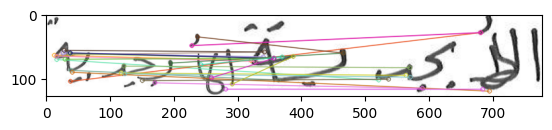

(<matplotlib.image.AxesImage at 0x2310552e3c0>, None)

In [17]:
#knnMatch
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img1 = cv.imread('./isolated_words_per_user/isolated_words_per_user/user001/user001_abjadiyah_038.png')          # queryImage
z = cv.imread('./isolated_words_per_user/isolated_words_per_user/user001/user001_abjadiyah_031.png') # trainImage

# Convert to grayscale if image is color (3 channels)
if len(img1.shape) == 3:
    gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
else:
    gray = img1


if len(z.shape) == 3:
    gray2 = cv.cvtColor(z, cv.COLOR_BGR2GRAY)
else:
    gray2 = z


# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray,None)

kp2, des2 = sift.detectAndCompute(gray2,None)

# BFMatcher with default params

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

print(len(good))

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,z,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()


